In [1]:
import os
import torch
import torchvision
from torch import nn, utils
from torchvision import transforms
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
import random
import os
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import os
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
from torch.utils.data import random_split, DataLoader

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models
from torchvision.models.resnet import ResNet18_Weights

from torchvision import models
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torchvision.models import EfficientNet_B0_Weights


# Exploring Dataset

In [2]:

BATCH_SIZE = 128
IMG_SIZE = 128

data_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.RandomHorizontalFlip(p=0.5)

])

class GarbageDataset(Dataset):
    def __init__(self, root_dir, transform=None):
     
        self.root_dir = root_dir
        self.classes = os.listdir(root_dir) # each folder in root_dir is a class
        self.class_to_idx = {cls_name: i for i, cls_name in enumerate(self.classes)}
        self.transform = transform
        self.image_paths = []
        self.labels = []

        for cls in self.classes:
            cls_folder = os.path.join(root_dir, cls)
            for img_name in os.listdir(cls_folder):
                self.image_paths.append(os.path.join(cls_folder, img_name))
                self.labels.append(self.class_to_idx[cls])

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert("RGB")  
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, label

dataset = GarbageDataset(root_dir="Garbage Classification", transform=data_transform)

print("Dataset size:", len(dataset))
print("Number of classes:", len(dataset.classes))
print("Classes:", dataset.classes)
print("Class to index mapping:", dataset.class_to_idx)


train_ratio = 0.7
val_ratio = 0.15
test_ratio = 0.15


total_size = len(dataset)
train_size = int(train_ratio * total_size)
val_size = int(val_ratio * total_size)
test_size = total_size - train_size - val_size  


train_set, val_set, test_set = random_split(dataset, [train_size, val_size, test_size])

train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_set, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_set, batch_size=BATCH_SIZE, shuffle=False)

print("\n")
print("Training set size:", len(train_set))
print("Validation set size:", len(val_set))
print("Test set size:", len(test_set))



Dataset size: 4650
Number of classes: 6
Classes: ['battery', 'glass', 'metal', 'organic', 'paper', 'plastic']
Class to index mapping: {'battery': 0, 'glass': 1, 'metal': 2, 'organic': 3, 'paper': 4, 'plastic': 5}


Training set size: 3255
Validation set size: 697
Test set size: 698


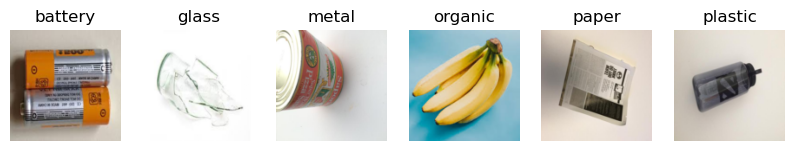

In [12]:
import matplotlib.pyplot as plt
import numpy as np

def show_sample_per_class(dataset):
    class_seen = set() 
    samples = []

    for image, label in dataset:
        if label not in class_seen:
            samples.append((image, label))
            class_seen.add(label)
        if len(class_seen) == len(dataset.classes):  
            break

    plt.figure(figsize=(10, 10))
    for i, (image, label) in enumerate(samples):
        image_np = image.permute(1, 2, 0).numpy().clip(0, 1)
        plt.subplot(1, len(samples), i + 1)
        plt.imshow(image_np)
        plt.title(dataset.classes[label])
        plt.axis("off")
    
    plt.show()


show_sample_per_class(dataset)

# Training Phase

Starting training...
Epoch 1/20, Training Loss: 0.6369, Training Accuracy: 0.7871
Epoch 1/20, Validation Loss: 0.4097, Validation Accuracy: 0.8666
Best model saved!
Epoch 2/20, Training Loss: 0.1568, Training Accuracy: 0.9475
Epoch 2/20, Validation Loss: 0.2056, Validation Accuracy: 0.9369
Best model saved!
Epoch 3/20, Training Loss: 0.0809, Training Accuracy: 0.9696
Epoch 3/20, Validation Loss: 0.2284, Validation Accuracy: 0.9498
Best model saved!
Epoch 4/20, Training Loss: 0.0861, Training Accuracy: 0.9748
Epoch 4/20, Validation Loss: 0.2224, Validation Accuracy: 0.9369
Epoch 5/20, Training Loss: 0.0730, Training Accuracy: 0.9751
Epoch 5/20, Validation Loss: 0.1810, Validation Accuracy: 0.9555
Best model saved!
Epoch 6/20, Training Loss: 0.0622, Training Accuracy: 0.9810
Epoch 6/20, Validation Loss: 0.1770, Validation Accuracy: 0.9570
Best model saved!
Epoch 7/20, Training Loss: 0.0422, Training Accuracy: 0.9859
Epoch 7/20, Validation Loss: 0.1938, Validation Accuracy: 0.9484
Epoch 8

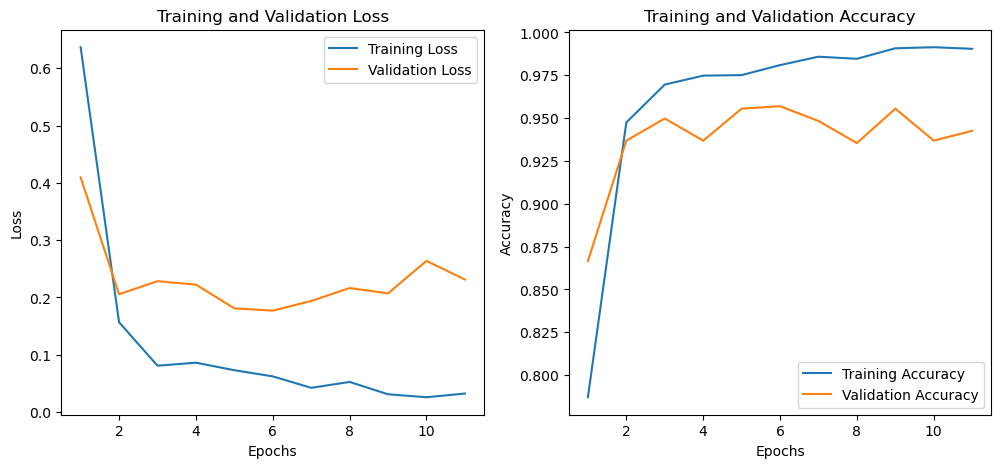

In [ ]:
model = models.efficientnet_b0(weights=EfficientNet_B0_Weights.IMAGENET1K_V1)

# Freeze the initial layers
for param in model.features[:3].parameters(): 
    param.requires_grad = False


num_classes = len(dataset.classes)
model.classifier = nn.Sequential(
    nn.Dropout(0.4),  
    nn.Linear(model.classifier[1].in_features, num_classes)
)


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.001)

early_stop_patience = 5
best_val_acc = 0.0
patience_counter = 0

print("Starting training...")

def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=10):
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []
    global best_val_acc, patience_counter

    for epoch in range(num_epochs):

        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()

            outputs = model(images)
            loss = criterion(outputs, labels)

            loss.backward()
            optimizer.step()

            running_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

        train_loss = running_loss / len(train_loader.dataset)
        train_accuracy = correct / total
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)
        
        print(f"Epoch {epoch+1}/{num_epochs}, Training Loss: {train_loss:.4f}, Training Accuracy: {train_accuracy:.4f}")

        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0
        
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item() * images.size(0)
                _, predicted = torch.max(outputs, 1)
                correct += (predicted == labels).sum().item()
                total += labels.size(0)

        val_loss /= len(val_loader.dataset)
        val_accuracy = correct / total
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)

        print(f"Epoch {epoch+1}/{num_epochs}, Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}")

        if val_accuracy > best_val_acc:
            best_val_acc = val_accuracy
            patience_counter = 0
            torch.save(model.state_dict(), 'baseline.pth')
            print("Best model saved!")
        else:
            patience_counter += 1
            if patience_counter >= early_stop_patience:
                print("Early stopping triggered.")
                break

    return train_losses, val_losses, train_accuracies, val_accuracies

num_epochs = 20
train_losses, val_losses, train_accuracies, val_accuracies = train_model(
    model, train_loader, val_loader, criterion, optimizer, num_epochs=num_epochs
)

# Plot training and validation losses and accuracies
epochs = range(1, len(train_losses) + 1)

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, label="Training Loss")
plt.plot(epochs, val_losses, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracies, label="Training Accuracy")
plt.plot(epochs, val_accuracies, label="Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Training and Validation Accuracy")
plt.legend()

plt.show()


# Basline Testing

In [5]:
model = models.efficientnet_b0(weights=EfficientNet_B0_Weights.IMAGENET1K_V1)
num_classes = 6
model.classifier = nn.Sequential(
    nn.Dropout(0.4),
    nn.Linear(model.classifier[1].in_features, num_classes)
)
model.load_state_dict(torch.load('baseline.pth'))

<All keys matched successfully>

Test Loss: 0.1657
Test Accuracy: 94.27%


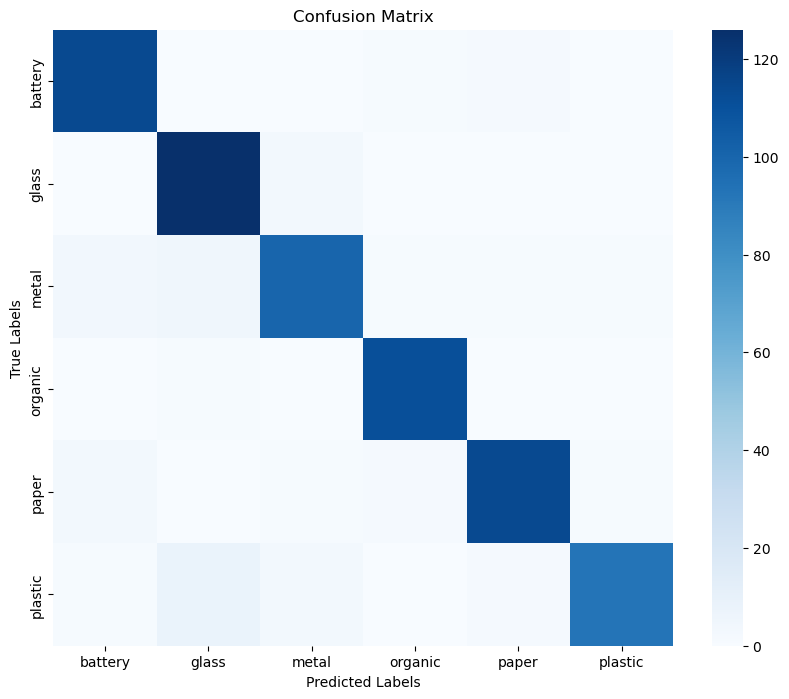

In [51]:
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Set the model to evaluation mode
model.eval()

test_loss = 0.0
correct = 0
total = 0

all_labels = []
all_predictions = []

# Disable gradient calculation for evaluation
with torch.no_grad():  
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        test_loss += loss.item()

        _, predicted = torch.max(outputs, 1)
        
        # Collect predictions and labels for the confusion matrix
        all_labels.extend(labels.cpu().numpy())
        all_predictions.extend(predicted.cpu().numpy())
        
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

# Compute the average test loss and accuracy
test_loss /= len(test_loader)
test_accuracy = 100 * correct / total

print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.2f}%")

# Generate confusion matrix
cm = confusion_matrix(all_labels, all_predictions)
num_classes = len(dataset.classes)  # Adjust according to your dataset
class_names = dataset.classes  # Replace with your actual class names if available

# Plot the confusion matrix using seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=False, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()


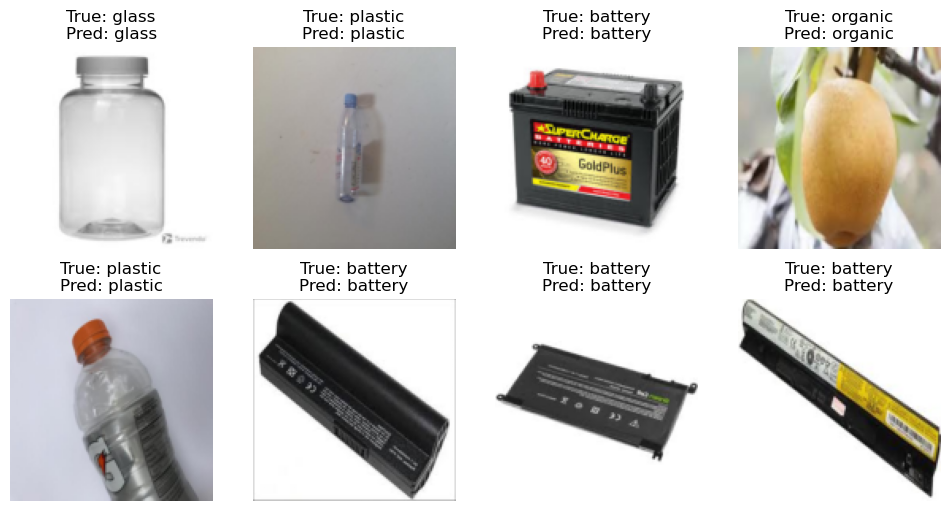

In [52]:
import matplotlib.pyplot as plt
import random

model.eval()

random_indices = random.sample(range(len(test_set)), BATCH_SIZE)
images, labels = zip(*[test_set[i] for i in random_indices]) 

images = torch.stack(images)
labels = torch.tensor(labels)

images, labels = images.to(device), labels.to(device)

with torch.no_grad():
    outputs = model(images)
    _, predictions = torch.max(outputs, 1)


num_samples = min(8, len(images)) 
plt.figure(figsize=(12, 6))
for i in range(num_samples):
    plt.subplot(2, 4, i + 1)
    image_np = images[i].cpu().permute(1, 2, 0).numpy().clip(0, 1)
    plt.imshow(image_np)
    plt.title(f"True: {dataset.classes[labels[i].item()]}\nPred: {dataset.classes[predictions[i].item()]}")
    plt.axis("off")

plt.show()


Processing images in class: Battery


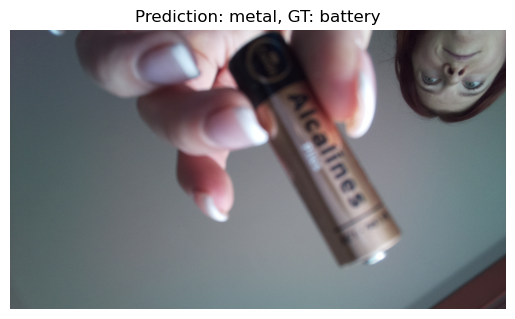

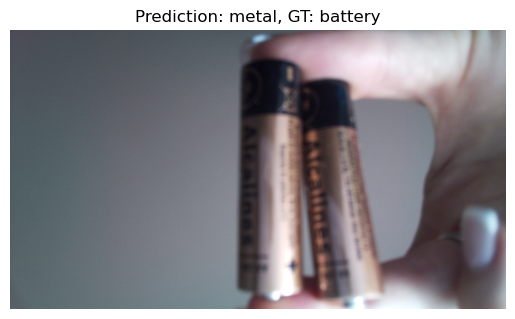

Processing images in class: Glass


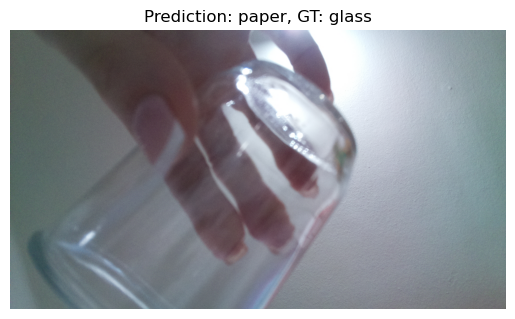

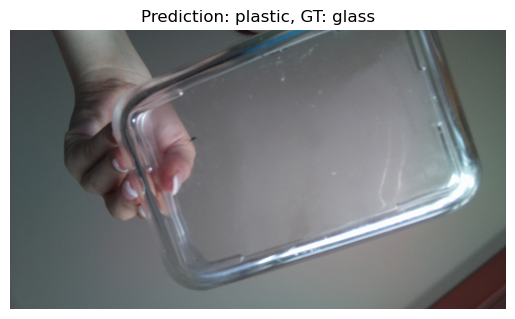

Processing images in class: Organic


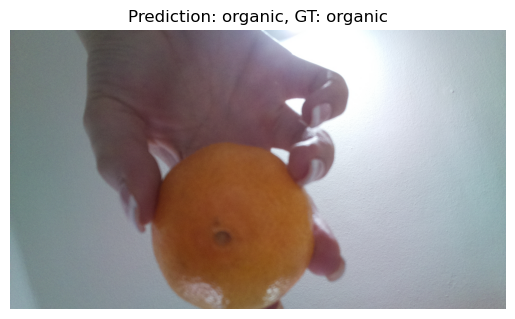

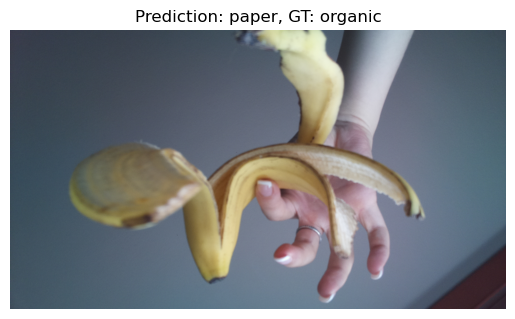

Processing images in class: Paper


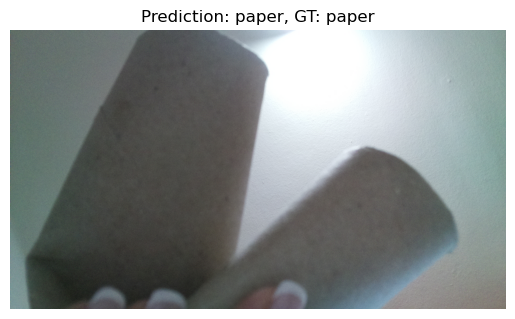

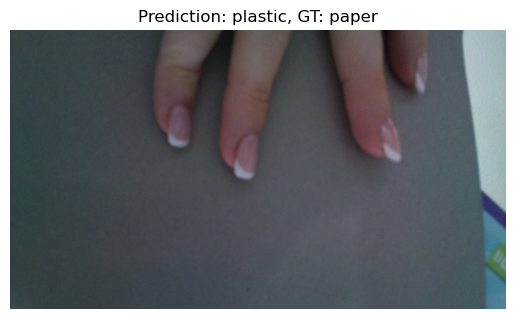

Processing images in class: Plastic


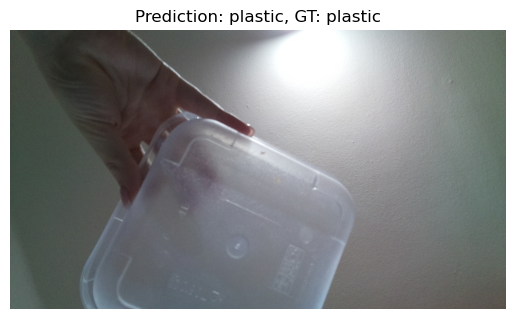

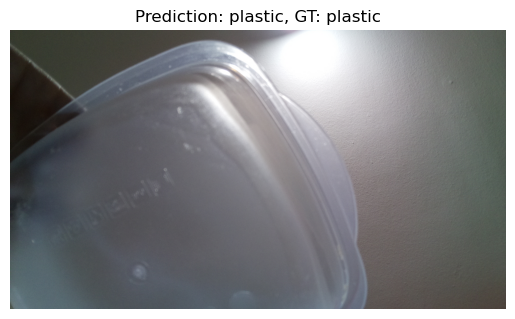

True labels: ['battery', 'battery', 'battery', 'battery', 'battery', 'battery', 'battery', 'battery', 'battery', 'battery', 'battery', 'glass', 'glass', 'glass', 'glass', 'glass', 'glass', 'glass', 'glass', 'glass', 'glass', 'glass', 'glass', 'glass', 'organic', 'organic', 'organic', 'organic', 'organic', 'organic', 'organic', 'organic', 'organic', 'organic', 'organic', 'organic', 'organic', 'organic', 'organic', 'organic', 'organic', 'organic', 'organic', 'organic', 'organic', 'organic', 'organic', 'organic', 'organic', 'organic', 'organic', 'organic', 'organic', 'paper', 'paper', 'paper', 'paper', 'paper', 'paper', 'paper', 'paper', 'paper', 'paper', 'paper', 'paper', 'paper', 'paper', 'paper', 'paper', 'paper', 'paper', 'paper', 'paper', 'paper', 'paper', 'paper', 'paper', 'paper', 'paper', 'paper', 'paper', 'paper', 'paper', 'paper', 'paper', 'paper', 'paper', 'paper', 'paper', 'paper', 'paper', 'paper', 'paper', 'paper', 'paper', 'paper', 'paper', 'paper', 'paper', 'paper', 'paper

In [9]:
import os
from PIL import Image
import torch
import torch.nn as nn
from torchvision import transforms, models
import matplotlib.pyplot as plt
from torchvision.models import EfficientNet_B0_Weights

IMG_SIZE = 128

# Set up the device and model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = models.efficientnet_b0(weights=EfficientNet_B0_Weights.IMAGENET1K_V1)
model.classifier = nn.Sequential(
    nn.Dropout(0.4),
    nn.Linear(model.classifier[1].in_features, 6)  # Adjusted for 6 classes
)

# Load your trained model weights
model.load_state_dict(torch.load('baseline.pth'))
model = model.to(device)
model.eval()

# Define the transformation
data_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor()
])


# Directory containing the dataset
dataset_dir = r"Custom Dataset"


true = []
pred = []

# Iterate through each class folder
for class_name in os.listdir(dataset_dir):
    class_dir = os.path.join(dataset_dir, class_name)
    
    # Skip if it's not a directory
    if not os.path.isdir(class_dir):
        continue
    
    print(f"Processing images in class: {class_name}")
    
    # Iterate through each image in the class folder
    
  
    for idx, img_name in enumerate(os.listdir(class_dir)):
      
        img_path = os.path.join(class_dir, img_name)
        
        # Open and preprocess the image
        image = Image.open(img_path).convert("RGB")
        image = data_transform(image).unsqueeze(0).to(device)
        
        # Perform inference
        with torch.no_grad():
            output = model(image)
            _, prediction = torch.max(output, 1)


        true.append(class_name.lower())
        pred.append(dataset.classes[prediction])

        if idx < 2:    
            plt.imshow(plt.imread(img_path))
            plt.title(f"Prediction: {dataset.classes[prediction]}, GT: {class_name.lower()}")
            plt.axis("off")
            plt.show()


# Compute accuracy

print(f"True labels: {true}")
print(f"Predictions: {pred}")

correct = sum([1 for t, p in zip(true, pred) if t == p])
accuracy = correct / len(true) * 100

print(f"Accuracy: {accuracy:.2f}%")

# Domain Adaptation

Custom dataset size: 50
Starting training...
Epoch 1/20, Training Loss: 5.3079, Training Accuracy: 0.2646
Epoch 1/20, Validation Loss: 1.8236, Validation Accuracy: 0.1593
Best model saved!
Epoch 2/20, Training Loss: 0.6724, Training Accuracy: 0.2323
Epoch 2/20, Validation Loss: 1.7963, Validation Accuracy: 0.2166
Best model saved!
Epoch 3/20, Training Loss: 1.5674, Training Accuracy: 0.5169
Epoch 3/20, Validation Loss: 1.8093, Validation Accuracy: 0.3013
Best model saved!
Epoch 4/20, Training Loss: 4.7501, Training Accuracy: 0.6785
Epoch 4/20, Validation Loss: 1.4852, Validation Accuracy: 0.3572
Best model saved!
Epoch 5/20, Training Loss: 1.9207, Training Accuracy: 0.6662
Epoch 5/20, Validation Loss: 1.2283, Validation Accuracy: 0.5581
Best model saved!
Epoch 6/20, Training Loss: 0.5353, Training Accuracy: 0.6200
Epoch 6/20, Validation Loss: 0.8080, Validation Accuracy: 0.7202
Best model saved!
Epoch 7/20, Training Loss: 0.4337, Training Accuracy: 0.6908
Epoch 7/20, Validation Loss: 0

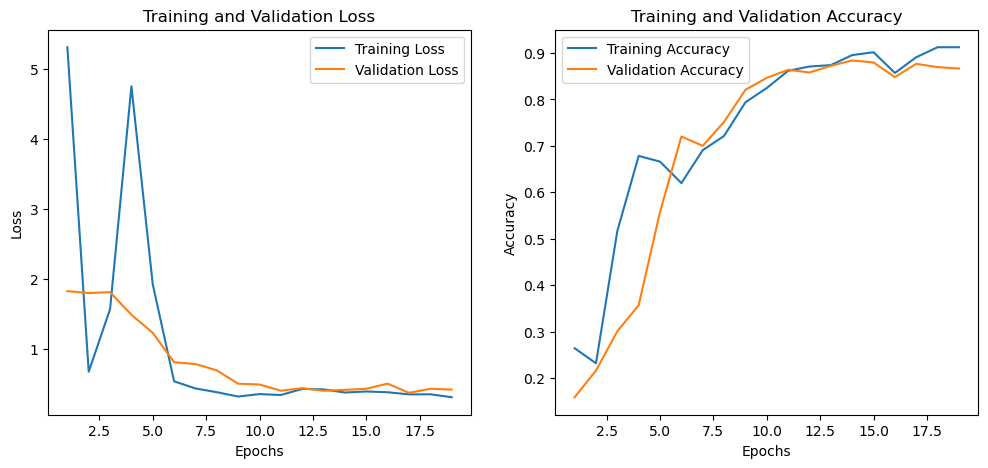

In [24]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from torchvision import models
import random

# DEFINE CUSTOM DATASET (UNLABELED DATA)
CUSTOM_BATCH_SIZE = 32

custom_dataset = GarbageDataset(root_dir="Custom Dataset", transform=data_transform)
custom_loader = DataLoader(custom_dataset, batch_size=CUSTOM_BATCH_SIZE, shuffle=False)

print("Custom dataset size:", len(custom_dataset))


# KL-DIVERGENCE LOSS FUNCTION
def compute_kl_divergence(p, q):
    return F.kl_div(F.log_softmax(p, dim=-1), F.softmax(q, dim=-1), reduction='batchmean')


# LOAD PRETRAINED MODEL
model = models.efficientnet_b0(weights="EfficientNet_B0_Weights.IMAGENET1K_V1")

for param in model.features[:3].parameters(): 
    param.requires_grad = False

num_classes = len(dataset.classes) 
model.classifier = nn.Sequential(
    nn.Dropout(0.4),  
    nn.Linear(model.classifier[1].in_features, num_classes)
)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.001)

early_stop_patience = 5
best_val_acc = 0.0
patience_counter = 0

print("Starting training...")

def train_model(model, train_loader, val_loader, custom_loader, criterion, optimizer, num_epochs=10):
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []
    global best_val_acc, patience_counter

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        
        unlabeled_iter = iter(custom_loader) # ITERATOR FOR UNLABELED DATA

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            
            # Get unlabeled batch
            try:
                unlabeled_images, _ = next(unlabeled_iter)
            except StopIteration:
                unlabeled_iter = iter(custom_loader)
                unlabeled_images, _ = next(unlabeled_iter)
            
            unlabeled_images = unlabeled_images.to(device)
            unlabeled_batch_size = unlabeled_images.size(0)
            
            # Sample labeled batch to match unlabeled batch size if they don't match
            if images.size(0) > unlabeled_batch_size:
                indices = random.sample(range(images.size(0)), unlabeled_batch_size)
                images = images[indices]
                labels = labels[indices]

            optimizer.zero_grad()

            # FORWARD PASS FOR LABELED BATCH
            outputs = model(images)
            loss = criterion(outputs, labels)

            # FORWARD PASS FOR UNLABELED BATCH
            with torch.no_grad():
                features_labeled = model.features(images)
                
            features_unlabeled = model.features(unlabeled_images)

            kl_loss = compute_kl_divergence(features_labeled, features_unlabeled)
            alpha = 0.1
            total_loss = (1-alpha) * loss + alpha * kl_loss  # COMBINED LOSS
            total_loss.backward()
            optimizer.step()

            running_loss += total_loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

        train_loss = running_loss / len(train_loader.dataset)
        train_accuracy = correct / total
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)
        
        print(f"Epoch {epoch+1}/{num_epochs}, Training Loss: {train_loss:.4f}, Training Accuracy: {train_accuracy:.4f}")

        # Validation step
        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0
        
        with torch.no_grad():
            
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item() * images.size(0)
                _, predicted = torch.max(outputs, 1)
                correct += (predicted == labels).sum().item()
                total += labels.size(0)

        val_loss /= len(val_loader.dataset)
        val_accuracy = correct / total
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)

        print(f"Epoch {epoch+1}/{num_epochs}, Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}")

        # Early stopping check
        if val_accuracy > best_val_acc:
            best_val_acc = val_accuracy
            patience_counter = 0
            torch.save(model.state_dict(), 'baseline_with_kl_loss.pth')
            print("Best model saved!")
        else:
            patience_counter += 1
            if patience_counter >= early_stop_patience:
                print("Early stopping triggered.")
                break

    return train_losses, val_losses, train_accuracies, val_accuracies

# Train the model
num_epochs = 20
train_losses, val_losses, train_accuracies, val_accuracies = train_model(
    model, train_loader, val_loader, custom_loader, criterion, optimizer, num_epochs=num_epochs
)

# Plot training and validation losses and accuracies
epochs = range(1, len(train_losses) + 1)

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, label="Training Loss")
plt.plot(epochs, val_losses, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracies, label="Training Accuracy")
plt.plot(epochs, val_accuracies, label="Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Training and Validation Accuracy")
plt.legend()

plt.show()


Test Loss: 0.3805
Test Accuracy: 89.11%


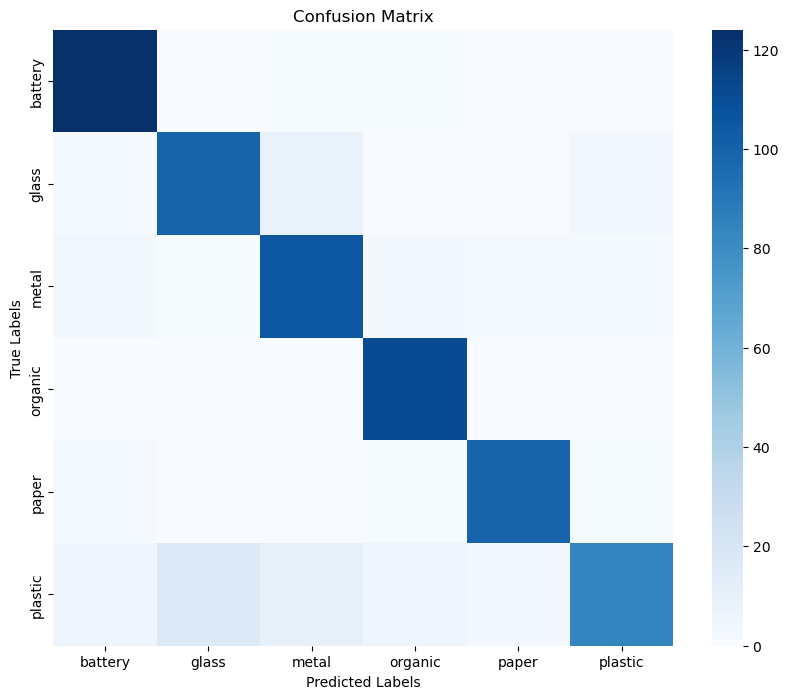

In [25]:
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

model.load_state_dict(torch.load('baseline_with_kl_loss.pth'))

# Set the model to evaluation mode
model.eval()

test_loss = 0.0
correct = 0
total = 0

all_labels = []
all_predictions = []

criterion = nn.CrossEntropyLoss()

# Disable gradient calculation for evaluation
with torch.no_grad():  
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        test_loss += loss.item()

        _, predicted = torch.max(outputs, 1)
        
        # Collect predictions and labels for the confusion matrix
        all_labels.extend(labels.cpu().numpy())
        all_predictions.extend(predicted.cpu().numpy())
        
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

# Compute the average test loss and accuracy
test_loss /= len(test_loader)
test_accuracy = 100 * correct / total

print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.2f}%")

# Generate confusion matrix
cm = confusion_matrix(all_labels, all_predictions)
num_classes = len(dataset.classes)  # Adjust according to your dataset
class_names = dataset.classes  # Replace with your actual class names if available

# Plot the confusion matrix using seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=False, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()


In [ ]:
import os
from PIL import Image
import torch
import torch.nn as nn
from torchvision import transforms, models
import matplotlib.pyplot as plt
from torchvision.models import EfficientNet_B0_Weights

# Set up the device and model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = models.efficientnet_b0(weights=EfficientNet_B0_Weights.IMAGENET1K_V1)
model.classifier = nn.Sequential(
    nn.Dropout(0.4),
    nn.Linear(model.classifier[1].in_features, 6)  # Adjusted for 6 classes
)

# Load your trained model weights
model.load_state_dict(torch.load('baseline_with_kl_loss.pth'))
model = model.to(device)
model.eval()

# Define the transformation
data_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor()
])


# Directory containing the dataset
dataset_dir = r"Custom Dataset"


true = []
pred = []

# Iterate through each class folder
for class_name in os.listdir(dataset_dir):
    class_dir = os.path.join(dataset_dir, class_name)
    
    # Skip if it's not a directory
    if not os.path.isdir(class_dir):
        continue
    
    print(f"Processing images in class: {class_name}")
    
    # Iterate through each image in the class folder
    for img_name in os.listdir(class_dir):
        img_path = os.path.join(class_dir, img_name)
        
        # Open and preprocess the image
        image = Image.open(img_path).convert("RGB")
        image = data_transform(image).unsqueeze(0).to(device)
        
        # Perform inference
        with torch.no_grad():
            output = model(image)
            _, prediction = torch.max(output, 1)

        true.append(class_name.lower())
        pred.append(dataset.classes[prediction])
    
        plt.imshow(plt.imread(img_path))
        plt.title(f"Prediction: {dataset.classes[prediction]}, GT: {class_name.lower()}")
        plt.axis("off")
        plt.show()


# Compute accuracy

correct = sum([1 for t, p in zip(true, pred) if t == p])
accuracy = correct / len(true) * 100

print(f"Accuracy: {accuracy:.2f}%")

# Fine-tuning

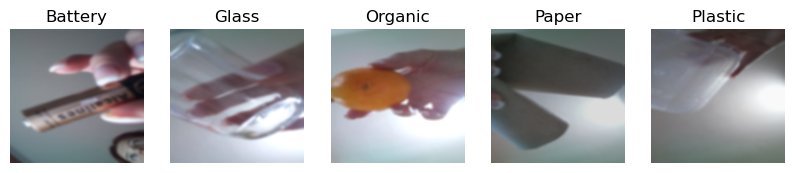

Custom dataset size: 178
Training set size: 115
Validation set size: 63
Starting training...
Epoch 1/150, Training Loss: 1.6244, Training Accuracy: 0.1913
Epoch 1/150, Validation Loss: 1.4271, Validation Accuracy: 0.3968
Best model saved!
Epoch 2/150, Training Loss: 1.0440, Training Accuracy: 0.8261
Epoch 2/150, Validation Loss: 1.2235, Validation Accuracy: 0.5873
Best model saved!
Epoch 3/150, Training Loss: 0.7009, Training Accuracy: 0.9130
Epoch 3/150, Validation Loss: 1.0097, Validation Accuracy: 0.7619
Best model saved!
Epoch 4/150, Training Loss: 0.4476, Training Accuracy: 0.9652
Epoch 4/150, Validation Loss: 0.8079, Validation Accuracy: 0.7778
Best model saved!
Epoch 5/150, Training Loss: 0.2354, Training Accuracy: 0.9826
Epoch 5/150, Validation Loss: 0.6424, Validation Accuracy: 0.8095
Best model saved!
Epoch 6/150, Training Loss: 0.1247, Training Accuracy: 1.0000
Epoch 6/150, Validation Loss: 0.5332, Validation Accuracy: 0.8413
Best model saved!
Epoch 7/150, Training Loss: 0.0

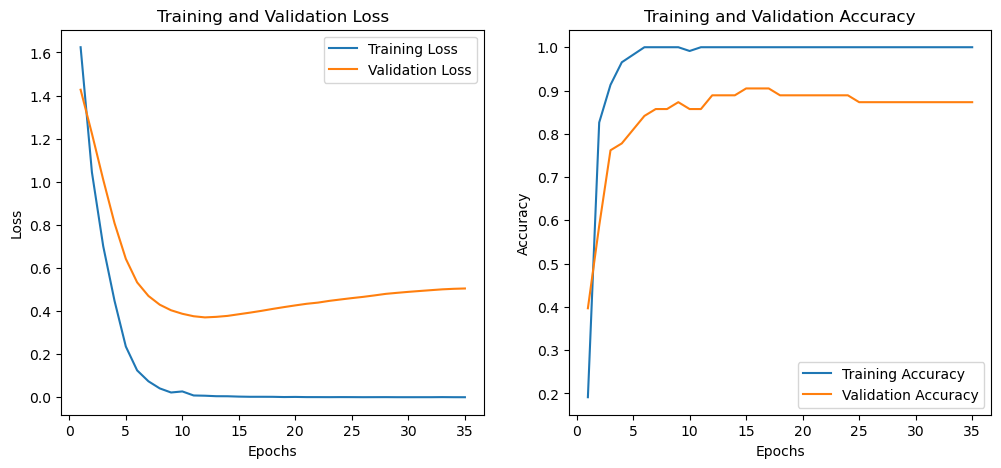

In [82]:
model = models.efficientnet_b0(weights=EfficientNet_B0_Weights.IMAGENET1K_V1)
model.classifier = nn.Sequential(
    nn.Dropout(0.4),  
    nn.Linear(model.classifier[1].in_features, 6)
)
model.load_state_dict(torch.load('baseline.pth'))

data_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomApply([transforms.RandomCrop(size=(100, 100))], p=0.4),
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomChoice([
        transforms.Lambda(lambda x: transforms.functional.rotate(x, angle))
        for angle in [0, 90, 180, 270]
    ]),
    transforms.ColorJitter(brightness=0.2),
    transforms.GaussianBlur(kernel_size=3),
    transforms.ToTensor()
])


custom_dataset = GarbageDataset(root_dir="Custom Dataset", transform=data_transform)
show_sample_per_class(custom_dataset)

num_classes = len(custom_dataset.classes)
model.classifier = nn.Sequential(
    nn.Dropout(0.5),  # Increased dropout rate
    nn.Linear(model.classifier[1].in_features, num_classes)
)

train_custom_data, val_custom_data = train_test_split(custom_dataset, test_size=0.35, random_state=42)

print("Custom dataset size:", len(custom_dataset))
print("Training set size:", len(train_custom_data))
print("Validation set size:", len(val_custom_data))

train_custom_loader = DataLoader(train_custom_data, batch_size=BATCH_SIZE, shuffle=True)
val_custom_loader = DataLoader(val_custom_data, batch_size=BATCH_SIZE, shuffle=False)

# Freeze backbone layers and fist 1 layers of the classifier

for param in model.features[:3].parameters(): 
    param.requires_grad = False

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(
    filter(lambda p: p.requires_grad, model.parameters()), 
    lr=0.001, weight_decay=1e-4  # L2 regularization with weight decay
)

early_stop_patience = 20
best_val_acc = 0.0
patience_counter = 0

print("Starting training...")

def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=10):
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []
    global best_val_acc, patience_counter

    for epoch in range(num_epochs):

        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()

            outputs = model(images)
            loss = criterion(outputs, labels)

            loss.backward()
            optimizer.step()

            running_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

        train_loss = running_loss / len(train_loader.dataset)
        train_accuracy = correct / total
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)
        
        print(f"Epoch {epoch+1}/{num_epochs}, Training Loss: {train_loss:.4f}, Training Accuracy: {train_accuracy:.4f}")

        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0
        
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item() * images.size(0)
                _, predicted = torch.max(outputs, 1)
                correct += (predicted == labels).sum().item()
                total += labels.size(0)

        val_loss /= len(val_loader.dataset)
        val_accuracy = correct / total
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)

        print(f"Epoch {epoch+1}/{num_epochs}, Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}")

        if val_accuracy > best_val_acc:
            best_val_acc = val_accuracy
            patience_counter = 0
            torch.save(model.state_dict(), 'finetuned.pth')
            print("Best model saved!")
        else:
            patience_counter += 1
            if patience_counter >= early_stop_patience:
                print("Early stopping triggered.")
                break

    return train_losses, val_losses, train_accuracies, val_accuracies

num_epochs = 150
train_losses, val_losses, train_accuracies, val_accuracies = train_model(
    model, train_custom_loader, val_custom_loader, criterion, optimizer, num_epochs=num_epochs
)

# Plot training and validation losses and accuracies
epochs = range(1, len(train_losses) + 1)

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, label="Training Loss")
plt.plot(epochs, val_losses, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracies, label="Training Accuracy")
plt.plot(epochs, val_accuracies, label="Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Training and Validation Accuracy")
plt.legend()

plt.show()


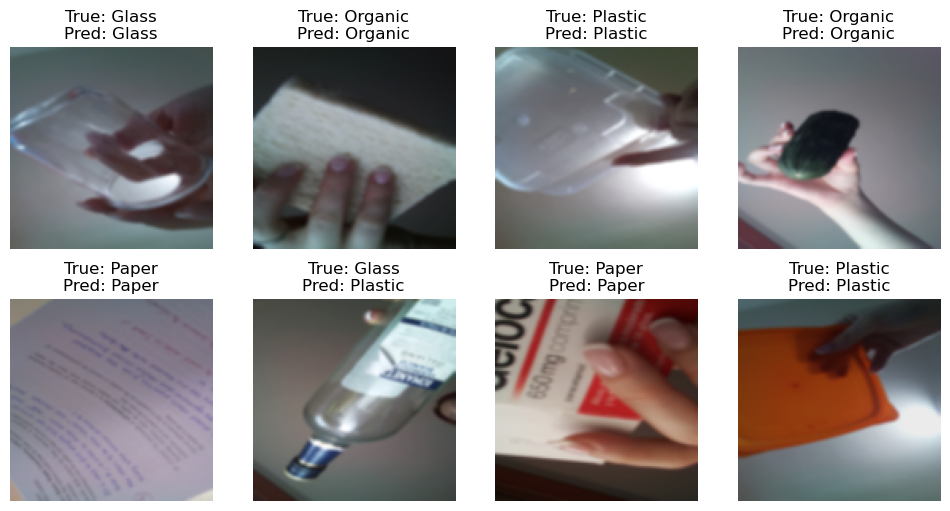

Test Loss: 0.0642
Test Accuracy: 90.48%


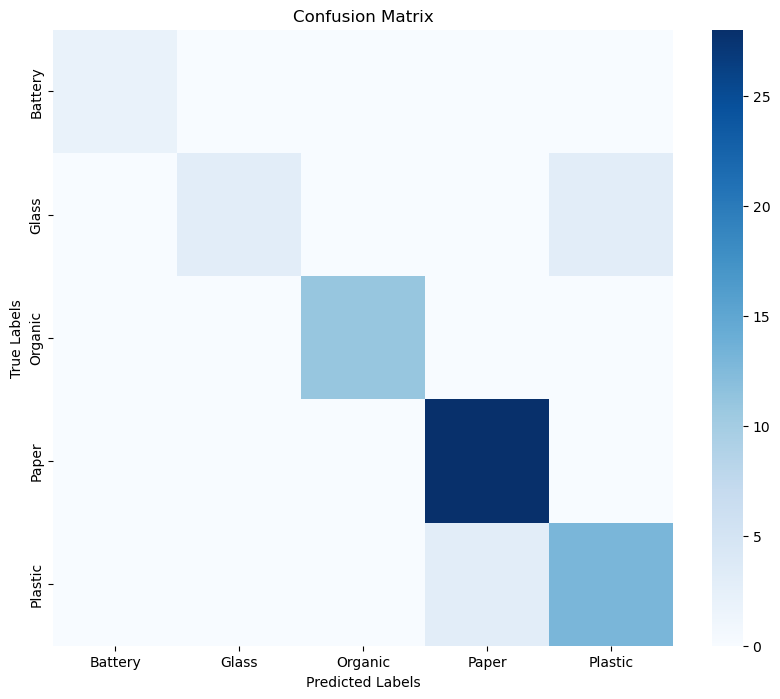

In [98]:
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

model.classifier = nn.Sequential(
    nn.Dropout(0.5),  
    nn.Linear(model.classifier[1].in_features, 5)
)

model.load_state_dict(torch.load('finetuned.pth'))

# Set the model to evaluation mode
model.eval()

test_loss = 0.0
correct = 0
total = 0

all_labels = []
all_predictions = []

criterion = nn.CrossEntropyLoss()

# Disable gradient calculation for evaluation
with torch.no_grad():  
    for images, labels in val_custom_loader:
        images, labels = images.to(device), labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        test_loss += loss.item()

        _, predicted = torch.max(outputs, 1)
        
        # Collect predictions and labels for the confusion matrix
        all_labels.extend(labels.cpu().numpy())
        all_predictions.extend(predicted.cpu().numpy())
        
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        # Plot the first batch of images in the validation set
        if total >= len(val_custom_loader.dataset):
            num_samples = min(8, len(images)) 
            plt.figure(figsize=(12, 6))
            for i in range(num_samples):
                plt.subplot(2, 4, i + 1)
                image_np = images[i].cpu().permute(1, 2, 0).numpy().clip(0, 1)
                plt.imshow(image_np)
                plt.title(f"True: {custom_dataset.classes[labels[i].item()]}\nPred: {custom_dataset.classes[predicted[i].item()]}")
                plt.axis("off")

            plt.show()

# Compute the average test loss and accuracy
test_loss /= len(test_loader)
test_accuracy = 100 * correct / total

print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.2f}%")

# Generate confusion matrix
cm = confusion_matrix(all_labels, all_predictions)
num_classes = len(custom_dataset.classes)  # Adjust according to your dataset
class_names = custom_dataset.classes  # Replace with your actual class names if available

# Plot the confusion matrix using seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=False, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()


In [99]:
import torch
import torch.nn.functional as F
from torch.autograd import Function
import numpy as np
import matplotlib.pyplot as plt
from torchvision import models, transforms
from PIL import Image

# Define a custom hook to save gradients
class SaveGradients(Function):
    @staticmethod
    def forward(ctx, x):
        ctx.save_for_backward(x)
        return x

    @staticmethod
    def backward(ctx, grad_output):
        return grad_output

# Grad-CAM function to apply to your model
class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None

        # Register hooks to access gradients and activations
        self.target_layer.register_forward_hook(self.save_activations)
        self.target_layer.register_backward_hook(self.save_gradients)

    def save_activations(self, module, input, output):
        self.activations = output

    def save_gradients(self, module, grad_in, grad_out):
        self.gradients = grad_out[0]

    def __call__(self, x):
        # Forward pass
        output = self.model(x)

        # Get the predicted class
        _, pred = torch.max(output, 1)
        pred_class = output[0, pred]

        # Backward pass to get gradients
        self.model.zero_grad()
        pred_class.backward(retain_graph=True)

        # Compute Grad-CAM
        pooled_gradients = torch.mean(self.gradients, dim=[0, 2, 3])
        activations = self.activations[0]
        for i in range(len(pooled_gradients)):
            activations[i, :, :] *= pooled_gradients[i]

        heatmap = torch.mean(activations, dim=0).cpu().detach().numpy()
        heatmap = np.maximum(heatmap, 0)
        heatmap /= heatmap.max()
        return heatmap, pred.item()


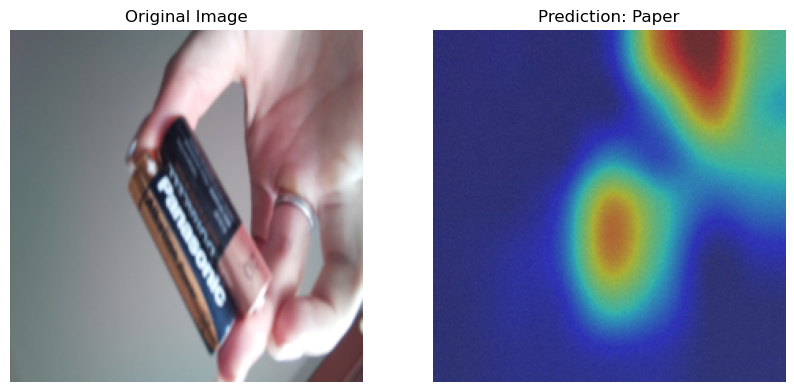

In [108]:
# Parameters
IMG_SIZE = 224

# Load and preprocess the image
img_path = r"C:\Users\User\OneDrive\Escritorio\AI Garbage Classification\AutoRecycle\Custom Dataset\Battery\photo_5.jpg"
image = Image.open(img_path).convert("RGB")

data_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor()
])

image_tensor = data_transform(image).unsqueeze(0)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load the model
model = models.efficientnet_b0(weights=models.EfficientNet_B0_Weights.IMAGENET1K_V1)
model.classifier = nn.Sequential(
    nn.Dropout(0.4),
    nn.Linear(model.classifier[1].in_features, 5)  # Adjusted for 5 classes
)
model.load_state_dict(torch.load('finetuned.pth'))
model = model.to(device)
model.eval()

# Apply Grad-CAM
target_layer = model.features[-1]  # The last convolutional layer
grad_cam = GradCAM(model, target_layer)

# Pass image through Grad-CAM
image_tensor = image_tensor.to(device)
heatmap, prediction = grad_cam(image_tensor)

# Convert heatmap to match image size
heatmap = np.uint8(255 * heatmap)
heatmap = Image.fromarray(heatmap).resize((IMG_SIZE, IMG_SIZE))
heatmap = np.array(heatmap)

# Display the result
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(image_tensor[0].permute(1, 2, 0).cpu().numpy().clip(0, 1))
plt.title("Original Image")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(image)
plt.imshow(heatmap, cmap='jet', alpha=0.5)  # Overlay heatmap with transparency
plt.title(f"Prediction: {custom_dataset.classes[prediction]}")
plt.axis("off")

plt.show()


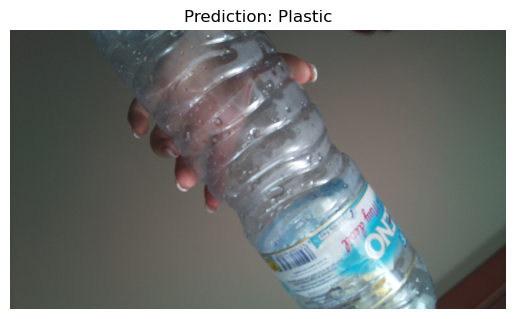

In [84]:
# Inference of an image

import os
from PIL import Image
import torch
import torch.nn as nn

img_path = r"C:\Users\User\OneDrive\Escritorio\AI Garbage Classification\AutoRecycle\Custom Dataset\Plastic\photo_45.jpg"
image = Image.open(img_path).convert("RGB")

data_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor()
])

image = data_transform(image).unsqueeze(0)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = models.efficientnet_b0(weights=EfficientNet_B0_Weights.IMAGENET1K_V1)
model.classifier = nn.Sequential(
    nn.Dropout(0.4),
    nn.Linear(model.classifier[1].in_features, 5)  # Adjusted for 6 classes
)

model.load_state_dict(torch.load('finetuned.pth'))

model = model.to(device)
model.eval()

with torch.no_grad():
    image = image.to(device)
    output = model(image)
    _, prediction = torch.max(output, 1)

plt.imshow(plt.imread(img_path))
plt.title(f"Prediction: {custom_dataset.classes[prediction]}")
plt.axis("off")
plt.show()


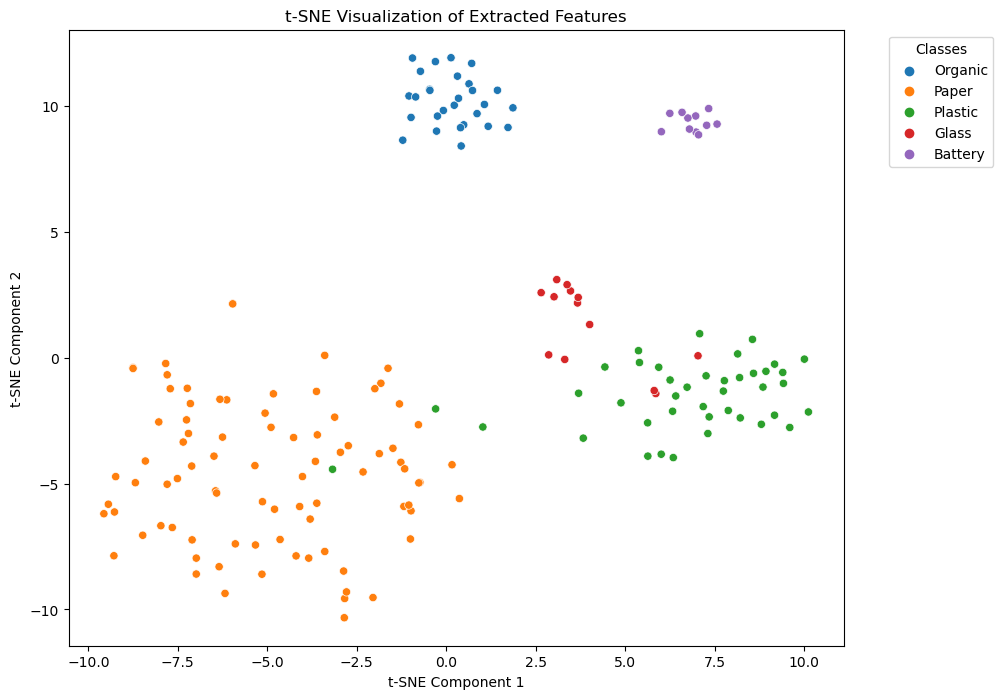

In [ ]:
import torch
# import pca
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Set the model to evaluation mode
model.eval()

# Lists to store extracted features and their corresponding labels
features = []
labels = []

# Disable gradient calculation for evaluation
with torch.no_grad():
    for loader in [train_custom_loader, val_custom_loader]:
        for images, lbls in loader:
            images = images.to(device)
            lbls = lbls.to(device)
            
            # Forward pass until the layer before classification to extract features
            outputs = model.features(images)  # Change this depending on the model architecture
            outputs = outputs.view(outputs.size(0), -1)  # Flatten the features if needed

            features.append(outputs.cpu().numpy())
            labels.extend(lbls.cpu().numpy())

# Concatenate all features and labels into single arrays
features = np.concatenate(features, axis=0)
labels = np.array(labels)

# Reduce dimensions using t-SNE
tsne = TSNE(n_components=2, random_state=42)
features_2d = tsne.fit_transform(features)

# Plot the t-SNE features

labels = [custom_dataset.classes[label] for label in labels]

plt.figure(figsize=(10, 8))
sns.scatterplot(x=features_2d[:, 0], y=features_2d[:, 1], hue=labels, palette="tab10")
plt.title("t-SNE Visualization of Extracted Features (Finetuned Model)")
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.legend(title="Classes", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()



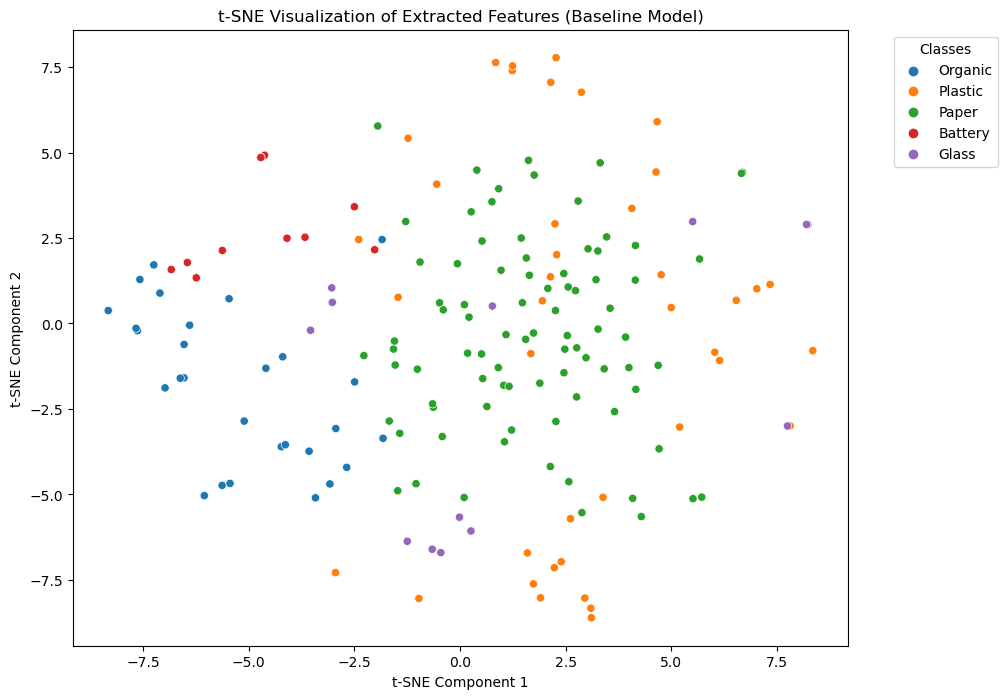

In [96]:
model = models.efficientnet_b0(weights=EfficientNet_B0_Weights.IMAGENET1K_V1)
model.classifier = nn.Sequential(
    nn.Dropout(0.4),  
    nn.Linear(model.classifier[1].in_features, 6)
)
model.load_state_dict(torch.load('baseline.pth'))

import torch
# import pca
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Set the model to evaluation mode
model.eval()

# Lists to store extracted features and their corresponding labels
features = []
labels = []

# Disable gradient calculation for evaluation
with torch.no_grad():
    for loader in [train_custom_loader, val_custom_loader]:
        for images, lbls in loader:
            images = images.to(device)
            lbls = lbls.to(device)
            
            # Forward pass until the layer before classification to extract features
            outputs = model.features(images)  # Change this depending on the model architecture
            outputs = outputs.view(outputs.size(0), -1)  # Flatten the features if needed

            features.append(outputs.cpu().numpy())
            labels.extend(lbls.cpu().numpy())

# Concatenate all features and labels into single arrays
features = np.concatenate(features, axis=0)
labels = np.array(labels)

# Reduce dimensions using t-SNE
tsne = TSNE(n_components=2, random_state=42)
features_2d = tsne.fit_transform(features)

# Plot the t-SNE features

labels = [custom_dataset.classes[label] for label in labels]

plt.figure(figsize=(10, 8))
sns.scatterplot(x=features_2d[:, 0], y=features_2d[:, 1], hue=labels, palette="tab10")
plt.title("t-SNE Visualization of Extracted Features (Baseline Model)")
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.legend(title="Classes", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()


